In [1]:
import numpy as np
import scipy as sp
import os
import itertools
import time
from pathlib import Path

import torch
from torch.utils.data import DataLoader

from qtorch.quant import Quantizer, quantizer
from qtorch.optim import OptimLP
from torch.optim import SGD
from qtorch import FloatingPoint
from qtorch.auto_low import sequential_lower
import sys
sys.path.append('..')

import math
from scipy.stats import norm # for GP
from scipy.stats import sem # standard error

from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()

import multiprocessing as mp

import itertools
import train_func as tf
# import utils

import mkl
mkl.set_num_threads(1)

import apgpy
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

from experiment_design import pivot_columns, greedy_stepwise_selection

from scipy.stats import sem
from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'weight': 'bold'})
rc('text', usetex=True)

from scipy.sparse.linalg import svds

In [2]:
def relative_error(mtx_true, mtx_pred):
    return np.linalg.norm(mtx_true - mtx_pred) / np.linalg.norm(mtx_true)

In [3]:
data_path = os.path.join(Path(os.getcwd()).parent.absolute(), 'data')

error_matrix = np.load(os.path.join(data_path, 'err_cifar100_epo100_complete.npy'))
memory_matrix = np.load(os.path.join(data_path, 'mem_cifar100_epo100_complete.npy'))
row_names = np.load(os.path.join(data_path, 'rownames_cifar100_epo100_complete.npy'))

In [4]:
s = np.linalg.svd(error_matrix, compute_uv=False)

[Text(0, 0, '0'), Text(0, 0, '5'), Text(0, 0, '10'), Text(0, 0, '15')]

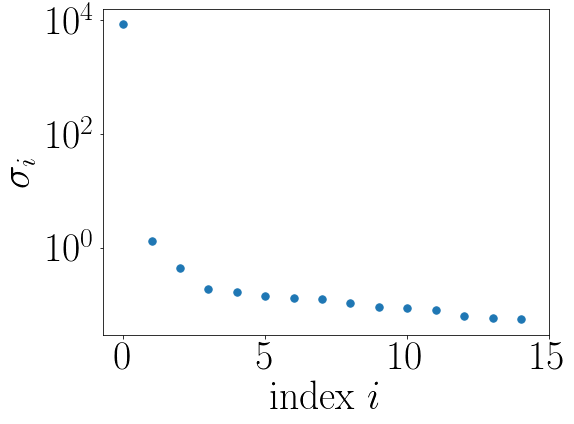

In [5]:
fontsize_axes = 40
scatter_size = 55

rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 22, 'weight': 'bold'})
rc('text', usetex=True)
fig, ax = plt.subplots(figsize=(8,6))

ax.scatter(np.arange(15), np.log(s[:15]), s=scatter_size)
ax.set_xlabel(r'index $i$', fontsize=fontsize_axes)
ax.set_ylabel(r'$\sigma_i$', fontsize=fontsize_axes)
ax.set_yticks([0, 2, 4])
ax.set_yticklabels([r'$10^{}$'.format(n) for n in [0, 2, 4]], fontsize=fontsize_axes)
ax.set_xticks([0, 5, 10, 15])
ax.set_xticklabels([0, 5, 10, 15], fontsize=fontsize_axes)

In [6]:
def is_pareto_efficient_dumb(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_efficient[i] = np.all(np.any(costs[:i]>c, axis=1)) and np.all(np.any(costs[i+1:]>c, axis=1))
    return is_efficient

In [7]:
def weighted_softimpute(X, M, W, lmbda, max_rank=None,
                        min_value=None, max_value=None,
                        apg_max_iter=2500, apg_eps=1e-6,
                        apg_use_restart=True):
    m = X.shape[0]
    n = X.shape[1]

    def prox(Z, t):
        Z = Z.reshape(m, n)

        # singular value shrinkage
        if max_rank is None:
            U, S, VT = svds(Z, k=min(Z.shape)-1)
            U = np.fliplr(U)
            S = np.flipud(S)
            VT = np.flipud(VT)

        else:
            U, S, VT = randomized_svd(Z, max_rank)
        S = np.maximum(S - lmbda*t, 0)
        Z = np.dot(U * S, VT)

        # clip values
        if min_value is not None:
            mask = Z < min_value
            if mask.sum() > 0:
                Z[mask] = min_value
        if max_value is not None:
            mask = Z > max_value
            if mask.sum() > 0:
                Z[mask] = max_value

        return Z.flatten()

    M_one_mask = (M == 1)
    masked_weights = W[M_one_mask]
    masked_X = X[M_one_mask]
    def grad(Z):
        grad = np.zeros((m, n))
        grad[M_one_mask] = (Z.reshape(m, n)[M_one_mask] - masked_X) * masked_weights
        return grad.flatten()

    X_hat = apgpy.solve(grad, prox, np.zeros(m*n),
                        max_iters=apg_max_iter,
                        eps=apg_eps,
                        use_gra=True,
                        use_restart=apg_use_restart,
                        quiet=True).reshape((m, n))
    return X_hat

In [8]:
# Metric 1: convergence

def get_closest_dist(true_all, pred):
    """
    true_all: a (n_points, dim_points) array. 
    pred: the single point to compute distance from.
    """
    dist_all = []
    for ref in true_all:
        dist_all.append(np.linalg.norm(pred - ref))
    return np.min(dist_all)    

def get_convergence_metric(error_true_at_true_frontier, memory_true_at_true_frontier, 
                          error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                          range_error_true, range_error_pred, range_memory):
    error_true_at_true_frontier_rescaled = error_true_at_true_frontier / range_error_true
    error_pred_at_pred_frontier_rescaled = error_pred_at_pred_frontier / range_error_pred
    memory_true_at_true_frontier_rescaled = memory_true_at_true_frontier / range_memory
    memory_true_at_pred_frontier_rescaled = memory_true_at_pred_frontier / range_memory
    
    costs_at_true_frontier = np.hstack((error_true_at_true_frontier_rescaled.reshape(-1, 1), 
                                        memory_true_at_true_frontier_rescaled.reshape(-1, 1)))
    costs_at_pred_frontier = np.hstack((error_pred_at_pred_frontier_rescaled.reshape(-1, 1), 
                                        memory_true_at_pred_frontier_rescaled.reshape(-1, 1)))
    
    dists = []
    for cost_pred in costs_at_pred_frontier:
        dists.append(get_closest_dist(costs_at_true_frontier, cost_pred))
    return np.average(dists)


# Metric 2: hypervolume difference
def hypervolume(x_all, y_all, x_max, y_max):
    x_all = np.array(x_all)
    y_all = np.array(y_all)
    
    assert all(x_all <= x_max), "there are x values larger than x_max"
    assert all(y_all <= y_max), "there are y values larger than y_max"
    assert len(x_all) == len(y_all)
    x_all_sorted = np.sort(x_all)
    y_all_rev_sorted = -np.sort(-y_all)
    y_all_rev_sorted_diff = -np.diff(y_all_rev_sorted)
    y_all_rev_sorted_diff = np.insert(y_all_rev_sorted_diff, 0, y_max-y_all_rev_sorted[0])
    return np.sum([(x_max - x_all[i]) * y_all_rev_sorted_diff[i] for i in range(len(x_all))])
    

def hypervolume_difference(error_true_at_true_frontier, memory_true_at_true_frontier, 
                error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                range_error_true, range_error_pred, range_memory, 
                max_error, max_memory):
    error_true_at_true_frontier_rescaled = error_true_at_true_frontier / range_error_true
    error_pred_at_pred_frontier_rescaled = error_pred_at_pred_frontier / range_error_pred
    memory_true_at_true_frontier_rescaled = memory_true_at_true_frontier / range_memory
    memory_true_at_pred_frontier_rescaled = memory_true_at_pred_frontier / range_memory
    max_error_rescaled = max_error / range_error_true
    max_memory_rescaled = max_memory / range_memory
    
    hypervolume_true = hypervolume(memory_true_at_true_frontier_rescaled, error_true_at_true_frontier_rescaled,
                                   max_memory_rescaled, max_error_rescaled)
    
    hypervolume_pred = hypervolume(memory_true_at_pred_frontier_rescaled, error_pred_at_pred_frontier_rescaled,
                                   max_memory_rescaled, max_error_rescaled)
    
    return np.abs(hypervolume_pred - hypervolume_true)

def hypervolume_difference_no_error_scaling(error_true_at_true_frontier, memory_true_at_true_frontier, 
                error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                max_error, max_memory):
    memory_true_at_true_frontier_rescaled = memory_true_at_true_frontier / max_memory
    memory_true_at_pred_frontier_rescaled = memory_true_at_pred_frontier / max_memory
    
    hypervolume_true = hypervolume(memory_true_at_true_frontier_rescaled, error_true_at_true_frontier,
                                   1, max_error)
    
    hypervolume_pred = hypervolume(memory_true_at_pred_frontier_rescaled, error_pred_at_pred_frontier,
                                   1, max_error)
    
    return np.abs(hypervolume_pred - hypervolume_true)
    

In [9]:
def uniform_sampling(ratio, matrix, initial_mask=None, seed=0):
    sampled_matrix = matrix.copy()
    np.random.seed(seed)
    if initial_mask is None:
        mask = np.random.choice([True, False], matrix.shape, p=[ratio, 1-ratio])
    else:
        assert initial_mask.shape == matrix.shape
        mask = initial_mask * np.random.choice([True, False], matrix.shape, p=[ratio, 1-ratio])
    sampled_matrix[np.invert(mask)] = np.nan
    return sampled_matrix, mask.astype(int)

def NormalizeData(data, min_value=0, max_value=1):
    pos = (data - np.min(data)) / (np.max(data) - np.min(data))    
    return min_value + pos * (max_value - min_value)

def NormalizeData_sqrt(data, min_value=0, max_value=1):
    pos = (data - np.min(data)) / (np.max(data) - np.min(data))    
    pos_sqrt = np.sqrt(pos)
    return min_value + pos_sqrt * (max_value - min_value)

def max_softmax(data, max_value, alpha=1):
    return np.exp(alpha * data) / np.exp(alpha * max_value)

def nonuniform_sampling(sampling_prob, matrix, initial_mask=None, seed=0):
    sampled_matrix = matrix.copy()
    np.random.seed(seed)
    if initial_mask is None:
        mask = (np.random.uniform(0, 1, sampling_prob.shape) < sampling_prob)
    else:
        assert initial_mask.shape == matrix.shape
        mask = initial_mask * (np.random.uniform(0, 1, sampling_prob.shape) < sampling_prob)
    sampled_matrix[np.invert(mask)] = np.nan
    return sampled_matrix, mask.astype(int)

In [10]:
observation_ratios = np.linspace(0.05, 0.3, 6).round(decimals=2)

In [11]:
observation_ratios

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ])

In [12]:
memory_matrix_part = memory_matrix
error_matrix_part = error_matrix

memory_matrix_part_flattened = memory_matrix_part.flatten()
error_matrix_part_flattened = error_matrix_part.flatten()

In [13]:
def run_uniform_sampling(idx_rep, idx_ratio):
    ratio = observation_ratios[idx_ratio]
    seed = int((idx_rep+1)*(idx_ratio+1))
    error_matrix_part_obs_unif, M_unif = uniform_sampling(ratio, error_matrix_part, seed=seed)
    W_unif = np.full(error_matrix_part_obs_unif.shape, 1)
    
    memory_usage = np.sum(memory_matrix_part[M_unif.astype(bool)])
    error_matrix_part_pred_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_obs_unif), M_unif, W_unif, 
                                           lmbda=.1, max_rank=5, min_value=0, max_value=1)
    
    dist_unif_all = []
    val_hypervolume_difference_all = []
    relative_error_all = []
    
    # loop over datasets
    for idx_dataset in range(error_matrix_part.shape[0]):
        relative_error_all.append(relative_error(error_matrix_part[idx_dataset], error_matrix_part_pred_unif[idx_dataset]))
        
        error_matrix_part_single_ds = error_matrix_part[idx_dataset]
        memory_matrix_part_single_ds = memory_matrix_part[idx_dataset]
        error_matrix_part_pred_unif_single_ds = error_matrix_part_pred_unif[idx_dataset]
        
        error_matrix_part_single_ds_flattened = error_matrix_part_single_ds.flatten()
        memory_matrix_part_single_ds_flattened = memory_matrix_part_single_ds.flatten()
        error_matrix_part_pred_unif_single_ds_flattened = error_matrix_part_pred_unif_single_ds.flatten()        
    
        # get true PF
        costs = np.hstack((memory_matrix_part_single_ds_flattened.reshape(-1, 1), 
                           error_matrix_part_single_ds_flattened.reshape(-1, 1)))
        is_efficient = is_pareto_efficient_dumb(costs)
        indices_true_frontier = np.where(is_efficient)[0]

        error_true_at_true_frontier = error_matrix_part_single_ds_flattened[indices_true_frontier]
        memory_true_at_true_frontier = memory_matrix_part_single_ds_flattened[indices_true_frontier]
        range_error_true = np.max(error_matrix_part_single_ds_flattened) - np.min(error_matrix_part_single_ds_flattened)

        # get predicted PF        
        costs_error_pred = np.hstack((memory_matrix_part_single_ds_flattened.reshape(-1, 1), 
                                      error_matrix_part_pred_unif_single_ds_flattened.reshape(-1, 1)))
        is_efficient_pred = is_pareto_efficient_dumb(costs_error_pred)
        indices_pred_frontier = np.where(is_efficient_pred)[0]
        error_pred_at_true_frontier = error_matrix_part_pred_unif_single_ds_flattened[indices_true_frontier]
        error_pred_at_pred_frontier = error_matrix_part_pred_unif_single_ds_flattened[indices_pred_frontier]
        memory_true_at_pred_frontier = memory_matrix_part_single_ds_flattened[indices_pred_frontier]
        max_error = 1
        range_error_pred = max_error
        max_memory = np.max(memory_matrix_part_flattened)
        range_memory_true = max_memory

        dist_unif_single_ds = get_convergence_metric(error_true_at_true_frontier, memory_true_at_true_frontier, 
                                          error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                                            max_error, max_error, max_memory)  # do not standardize errors for now


        val_hypervolume_difference_single_ds = hypervolume_difference(error_true_at_true_frontier, memory_true_at_true_frontier,
                                                           error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                                                           max_error, max_error, max_memory, max_error, max_memory)
    
        dist_unif_all.append(dist_unif_single_ds)
        val_hypervolume_difference_all.append(val_hypervolume_difference_single_ds)
        
    dist_unif_all = np.array(dist_unif_all)    
    val_hypervolume_difference_all = np.array(val_hypervolume_difference_all)
    relative_error_all = np.array(relative_error_all)
    
    return relative_error_all, dist_unif_all, val_hypervolume_difference_all, memory_usage

In [14]:
n_reps = 100
combs = list(itertools.product(range(n_reps), range(len(observation_ratios))))

p1 = mp.Pool(100)
results = [p1.apply_async(run_uniform_sampling, args=[idx_rep, idx_ratio]) for idx_rep, idx_ratio in combs]
p1.close()
p1.join()

In [15]:
n_datasets = error_matrix_part.shape[0]

relative_error_unif_all = np.full((n_reps, len(observation_ratios), n_datasets), np.nan)
dist_unif_all = np.full((n_reps, len(observation_ratios), n_datasets), np.nan)
hypervolume_difference_unif_all = np.full((n_reps, len(observation_ratios), n_datasets), np.nan)
memory_usage_all = np.full((n_reps, len(observation_ratios)), np.nan)

for i, (idx_rep, idx_ratio) in enumerate(combs):
    relative_error_unif_all[idx_rep, idx_ratio] = results[i].get()[0]
    dist_unif_all[idx_rep, idx_ratio] = results[i].get()[1]
    hypervolume_difference_unif_all[idx_rep, idx_ratio] = results[i].get()[2]
    memory_usage_all[idx_rep, idx_ratio] = results[i].get()[3]

memory_usage_mean = np.average(memory_usage_all, axis=0)

relative_error_unif_by_dataset_mean = np.average(relative_error_unif_all, axis=0)
relative_error_unif_by_dataset_median = np.median(relative_error_unif_all, axis=0)
relative_error_unif_by_dataset_std = np.std(relative_error_unif_all, axis=0)

dist_unif_by_dataset_mean = np.average(dist_unif_all, axis=0)
dist_unif_by_dataset_median = np.median(dist_unif_all, axis=0)
dist_unif_by_dataset_std = np.std(dist_unif_all, axis=0)

hypervolume_difference_unif_by_dataset_mean = np.average(hypervolume_difference_unif_all, axis=0)
hypervolume_difference_unif_by_dataset_median = np.median(hypervolume_difference_unif_all, axis=0)
hypervolume_difference_unif_by_dataset_std = np.std(hypervolume_difference_unif_all, axis=0)

Text(0, 0.5, 'relative error')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


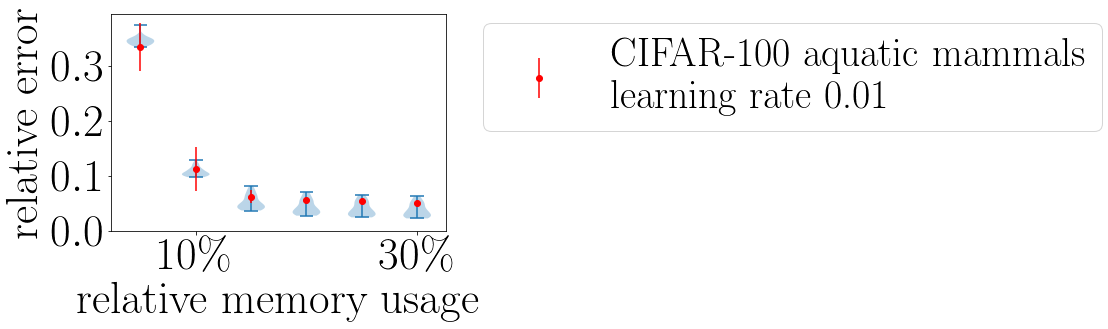

In [16]:
fontsize_axes = 45
fontsize_legend = 40

fig, ax = plt.subplots(nrows=1, ncols=1)
xtick_pos = [2, 6]
ax.set_xticks(xtick_pos)
xtick_labels = ['{:.0f}\%'.format(100*item) for item in [0.1, 0.3]]
ax.set_xticklabels(xtick_labels, fontsize=fontsize_axes)


ax.violinplot(relative_error_unif_by_dataset_mean.T, showextrema=True)
ax.errorbar(np.arange(len(observation_ratios))+1, relative_error_unif_by_dataset_mean[:, 0], 
            relative_error_unif_by_dataset_std[:, 0], fmt='o', color='red', label='CIFAR-100 aquatic mammals \n learning rate 0.01') # cifar10
plt.yticks(fontsize=fontsize_axes)
plt.ylim(bottom=0)
plt.legend(loc='upper', bbox_to_anchor=(1.05, 1.05), fontsize=fontsize_legend, ncol=1)
ax.set_xlabel('relative memory usage', fontsize=fontsize_axes)
ax.set_ylabel('relative error', fontsize=fontsize_axes)

Text(0, 0.5, 'convergence')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


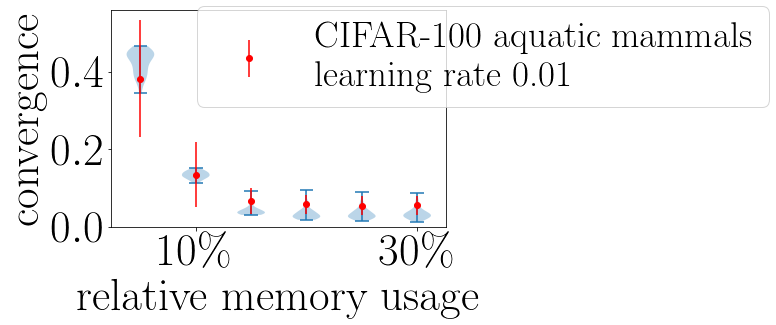

In [17]:
fontsize_axes = 45
fontsize_legend = 40

fig, ax = plt.subplots(nrows=1, ncols=1)

xtick_pos = [2,6]
ax.set_xticks(xtick_pos)
xtick_labels = ['{:.0f}\%'.format(100*item) for item in [0.1, 0.3]]
ax.set_xticklabels(xtick_labels, fontsize=fontsize_axes)

ax.violinplot(dist_unif_by_dataset_mean.T, showextrema=True)
ax.errorbar(np.arange(len(observation_ratios))+1, dist_unif_by_dataset_mean[:, 0], 
            dist_unif_by_dataset_std[:, 0], fmt='o', color='red',  label='CIFAR-100 aquatic mammals \n learning rate 0.01') 
plt.yticks(fontsize=fontsize_axes)
plt.ylim(bottom=0)
plt.legend(loc='upper', bbox_to_anchor=(.2, 1.1), fontsize=fontsize_legend-3, ncol=1)
ax.set_xlabel('relative memory usage', fontsize=fontsize_axes)
ax.set_ylabel('convergence', fontsize=fontsize_axes)

Text(0, 0.5, 'HyperDiff')

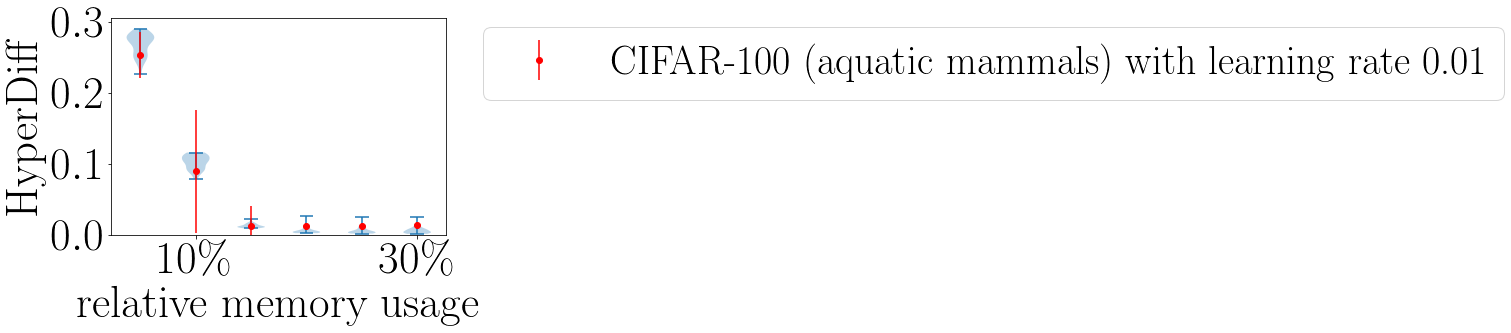

In [18]:
fontsize_axes = 45
fontsize_legend = 40

fig, ax = plt.subplots(nrows=1, ncols=1)

xtick_pos = [2, 6]
ax.set_xticks(xtick_pos)
xtick_labels = ['{:.0f}\%'.format(100*item) for item in [0.1, 0.3]]
ax.set_xticklabels(xtick_labels, fontsize=fontsize_axes)


ax.violinplot(hypervolume_difference_unif_by_dataset_mean.T, showextrema=True)
ax.errorbar(np.arange(len(observation_ratios))+1, hypervolume_difference_unif_by_dataset_mean[:, 0], 
            hypervolume_difference_unif_by_dataset_std[:, 0], fmt='o', color='red', label='CIFAR-100 (aquatic mammals) with learning rate 0.01') 
plt.yticks(fontsize=fontsize_axes)
plt.ylim(bottom=0)
legend = plt.legend(loc='upper', bbox_to_anchor=(1.05, 1.05), fontsize=fontsize_legend, ncol=1)
ax.set_xlabel('relative memory usage', fontsize=fontsize_axes)
ax.set_ylabel('HyperDiff', fontsize=fontsize_axes)

In [19]:
def run_nonuniform_sampling_scaling(idx_rep, idx_max_prob):
    max_prob = max_prob_all[idx_max_prob]
    seed = int((idx_rep+1)*(idx_max_prob+1))
#     print("rep {}, max prob {} (random seed {})".format(idx_rep, max_prob, seed))
    sampling_prob_non_unif = sampling_prob_non_unif_original * max_prob
    error_matrix_part_obs_non_unif, M_non_unif = nonuniform_sampling(sampling_prob_non_unif, error_matrix_part, seed=seed)
    W_non_unif = 1/sampling_prob_non_unif
    error_matrix_part_pred_non_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_obs_non_unif), M_non_unif, W_non_unif, 
                                       lmbda=.1, max_rank=5, min_value=0, max_value=1)

    memory_usage = np.sum(memory_matrix_part[M_non_unif.astype(bool)])
    sampling_ratio = np.sum(M_non_unif) / np.prod(M_non_unif.shape)
    
    dist_non_unif_all = []
    val_hypervolume_difference_all = []
    relative_error_all = []
    
    # loop over datasets
    for idx_dataset in range(error_matrix_part.shape[0]):
        relative_error_all.append(relative_error(error_matrix_part[idx_dataset], error_matrix_part_pred_non_unif[idx_dataset]))
        
        error_matrix_part_single_ds = error_matrix_part[idx_dataset]
        memory_matrix_part_single_ds = memory_matrix_part[idx_dataset]
        error_matrix_part_pred_non_unif_single_ds = error_matrix_part_pred_non_unif[idx_dataset]
        
        error_matrix_part_single_ds_flattened = error_matrix_part_single_ds.flatten()
        memory_matrix_part_single_ds_flattened = memory_matrix_part_single_ds.flatten()
        error_matrix_part_pred_non_unif_single_ds_flattened = error_matrix_part_pred_non_unif_single_ds.flatten()        
    
        # get true PF
        costs = np.hstack((memory_matrix_part_single_ds_flattened.reshape(-1, 1), 
                           error_matrix_part_single_ds_flattened.reshape(-1, 1)))
        is_efficient = is_pareto_efficient_dumb(costs)
        indices_true_frontier = np.where(is_efficient)[0]

        error_true_at_true_frontier = error_matrix_part_single_ds_flattened[indices_true_frontier]
        memory_true_at_true_frontier = memory_matrix_part_single_ds_flattened[indices_true_frontier]
        range_error_true = np.max(error_matrix_part_single_ds_flattened) - np.min(error_matrix_part_single_ds_flattened)

        # get predicted PF        
        costs_error_pred = np.hstack((memory_matrix_part_single_ds_flattened.reshape(-1, 1), 
                                      error_matrix_part_pred_non_unif_single_ds_flattened.reshape(-1, 1)))
        is_efficient_pred = is_pareto_efficient_dumb(costs_error_pred)
        indices_pred_frontier = np.where(is_efficient_pred)[0]
        error_pred_at_true_frontier = error_matrix_part_pred_non_unif_single_ds_flattened[indices_true_frontier]
        error_pred_at_pred_frontier = error_matrix_part_pred_non_unif_single_ds_flattened[indices_pred_frontier]
        memory_true_at_pred_frontier = memory_matrix_part_single_ds_flattened[indices_pred_frontier]
        
        max_error = 1
        max_memory = np.max(memory_matrix_part.flatten())

        dist_non_unif_single_ds = get_convergence_metric(error_true_at_true_frontier, memory_true_at_true_frontier, 
                                          error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                                            max_error, max_error, max_memory)  # errors not standardized

        val_hypervolume_difference_single_ds = hypervolume_difference(error_true_at_true_frontier, memory_true_at_true_frontier,
                                                           error_pred_at_pred_frontier, memory_true_at_pred_frontier,
                                                           max_error, max_error, max_memory, max_error, max_memory)
    
        dist_non_unif_all.append(dist_non_unif_single_ds)
        val_hypervolume_difference_all.append(val_hypervolume_difference_single_ds)
        
    dist_non_unif_all = np.array(dist_non_unif_all)    
    val_hypervolume_difference_all = np.array(val_hypervolume_difference_all)
    relative_error_all = np.array(relative_error_all)
    
    return relative_error_all, dist_non_unif_all, val_hypervolume_difference_all, sampling_ratio, memory_usage

In [20]:
max_prob_all = np.linspace(0.1, 1, 10).round(decimals=1)

In [21]:
max_prob_all

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [22]:
inverse_memory_sorted = np.sort((1/memory_matrix_part).flatten())
inverse_memory_cdf = np.arange(len(inverse_memory_sorted)) / (len(inverse_memory_sorted) - 1)
sampling_prob_non_unif_original = inverse_memory_cdf[np.argsort(np.argsort((1/memory_matrix_part).flatten())).reshape(memory_matrix_part.shape)]

In [23]:
n_reps = 100
combs = list(itertools.product(range(n_reps), range(len(max_prob_all))))

p1 = mp.Pool(100)
results = [p1.apply_async(run_nonuniform_sampling_scaling, args=[idx_rep, idx_max_prob]) for idx_rep, idx_max_prob in combs]
p1.close()
p1.join()

In [24]:
n_datasets = error_matrix_part.shape[0]

relative_error_non_unif_all = np.full((n_reps, len(max_prob_all), n_datasets), np.nan)
dist_non_unif_all = np.full((n_reps, len(max_prob_all), n_datasets), np.nan)
hypervolume_difference_non_unif_all = np.full((n_reps, len(max_prob_all), n_datasets), np.nan)
memory_usage_non_unif_all = np.full((n_reps, len(max_prob_all)), np.nan)
sampling_ratio_non_unif_all = np.full((n_reps, len(max_prob_all)), np.nan)

for i, (idx_rep, idx_prob) in enumerate(combs):
    relative_error_non_unif_all[idx_rep, idx_prob] = results[i].get()[0]
    dist_non_unif_all[idx_rep, idx_prob] = results[i].get()[1]
    hypervolume_difference_non_unif_all[idx_rep, idx_prob] = results[i].get()[2]
    sampling_ratio_non_unif_all[idx_rep, idx_prob] = results[i].get()[3]
    memory_usage_non_unif_all[idx_rep, idx_prob] = results[i].get()[4]

sampling_ratio_non_unif_mean = np.average(sampling_ratio_non_unif_all, axis=0)
memory_usage_non_unif_mean = np.average(memory_usage_non_unif_all, axis=0)

relative_error_non_unif_by_dataset_mean = np.average(relative_error_non_unif_all, axis=0)
relative_error_non_unif_by_dataset_median = np.median(relative_error_non_unif_all, axis=0)
relative_error_non_unif_by_dataset_std = np.std(relative_error_non_unif_all, axis=0)

dist_non_unif_by_dataset_mean = np.average(dist_non_unif_all, axis=0)
dist_non_unif_by_dataset_median = np.median(dist_non_unif_all, axis=0)
dist_non_unif_by_dataset_std = np.std(dist_non_unif_all, axis=0)

hypervolume_difference_non_unif_by_dataset_mean = np.average(hypervolume_difference_non_unif_all, axis=0)
hypervolume_difference_non_unif_by_dataset_median = np.median(hypervolume_difference_non_unif_all, axis=0)
hypervolume_difference_non_unif_by_dataset_std = np.std(hypervolume_difference_non_unif_all, axis=0)

In [25]:
memory_usage_non_unif_mean_TB = memory_usage_non_unif_mean / 1024**2

memory_non_unif = np.array(['{p:.2f}'.format(p=memory_usage_non_unif_mean[np.where(max_prob_all == max_prob)[0]][0]/1024**2) 
                for max_prob in max_prob_all]).astype(float)

memory_usage_non_unif_mean_ratio = memory_usage_non_unif_mean / np.sum(memory_matrix_part)

Text(0, 0.5, 'relative error')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


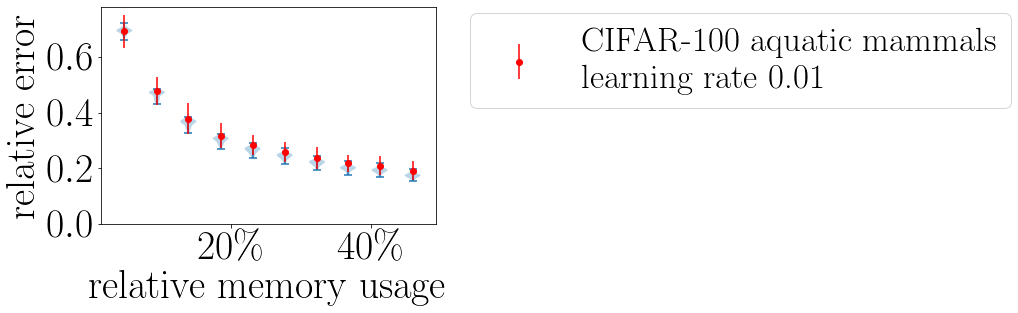

In [26]:
fontsize_axes = 40
fontsize_legend = 35

fig, ax = plt.subplots(nrows=1, ncols=1)

positions = memory_usage_non_unif_mean_ratio / memory_usage_non_unif_mean_ratio[0]

xtick_percentages = [0, 20, 40]
xtick_labels = ['{:.0f}\%'.format(item) for item in xtick_percentages]
xtick_pos = [item / (100*memory_usage_non_unif_mean_ratio[0]) for item in xtick_percentages]
ax.set_xticks(xtick_pos)
ax.set_xticklabels(xtick_labels, fontsize=fontsize_axes)

ax.violinplot(relative_error_non_unif_by_dataset_mean.T, positions=positions, showextrema=True)

ax.errorbar(positions, relative_error_non_unif_by_dataset_mean[:, 0], 
            relative_error_non_unif_by_dataset_std[:, 0], fmt='o', color='red', label='CIFAR-100 aquatic mammals \n learning rate 0.01') # cifar10
plt.yticks(fontsize=fontsize_axes)
plt.ylim(bottom=0)
plt.legend(loc='upper', bbox_to_anchor=(1.05, 1.05), fontsize=fontsize_legend, ncol=1)
ax.set_xlabel('relative memory usage', fontsize=fontsize_axes)
ax.set_ylabel('relative error', fontsize=fontsize_axes)

Text(0, 0.5, 'convergence')

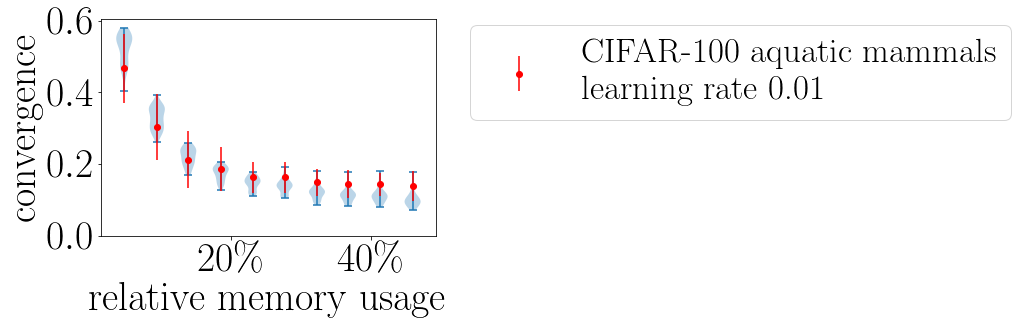

In [27]:
fontsize_axes = 40
fontsize_legend = 35

fig, ax = plt.subplots(nrows=1, ncols=1)

positions = memory_usage_non_unif_mean_ratio / memory_usage_non_unif_mean_ratio[0]

xtick_percentages = [0, 20, 40]
xtick_labels = ['{:.0f}\%'.format(item) for item in xtick_percentages]
xtick_pos = [item / (100*memory_usage_non_unif_mean_ratio[0]) for item in xtick_percentages]
ax.set_xticks(xtick_pos)
ax.set_xticklabels(xtick_labels, fontsize=fontsize_axes)

ax.violinplot(dist_non_unif_by_dataset_mean.T, positions=positions, showextrema=True)
    
ax.errorbar(positions, dist_non_unif_by_dataset_mean[:, 0], 
            dist_non_unif_by_dataset_std[:, 0], fmt='o', color='red', label='CIFAR-100 aquatic mammals \n learning rate 0.01') # cifar10
plt.yticks(fontsize=fontsize_axes)
plt.ylim(bottom=0)
plt.legend(loc='upper', bbox_to_anchor=(1.05, 1.05), fontsize=fontsize_legend, ncol=1)
ax.set_xlabel('relative memory usage', fontsize=fontsize_axes)
ax.set_ylabel('convergence', fontsize=fontsize_axes)

Text(0, 0.5, 'HyperDiff')

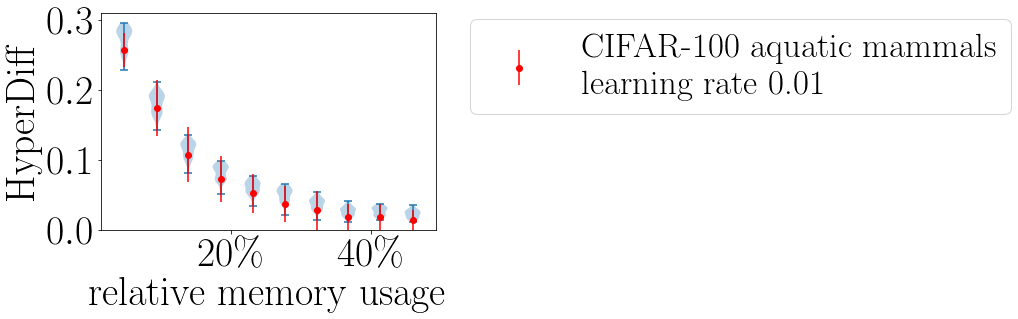

In [28]:
fontsize_axes = 40
fontsize_legend = 35

fig, ax = plt.subplots(nrows=1, ncols=1)

positions = memory_usage_non_unif_mean_ratio / memory_usage_non_unif_mean_ratio[0]

xtick_percentages = [0, 20, 40]
xtick_labels = ['{:.0f}\%'.format(item) for item in xtick_percentages]
xtick_pos = [item / (100*memory_usage_non_unif_mean_ratio[0]) for item in xtick_percentages]
ax.set_xticks(xtick_pos)
ax.set_xticklabels(xtick_labels, fontsize=fontsize_axes)


ax.violinplot(hypervolume_difference_non_unif_by_dataset_mean.T, positions=positions, showextrema=True)

ax.errorbar(positions, hypervolume_difference_non_unif_by_dataset_mean[:, 0], 
            hypervolume_difference_non_unif_by_dataset_std[:, 0], fmt='o', color='red', label='CIFAR-100 aquatic mammals \n learning rate 0.01') # cifar10
plt.yticks(fontsize=fontsize_axes)
plt.ylim(bottom=0)
plt.legend(loc='upper', bbox_to_anchor=(1.05, 1.05), fontsize=fontsize_legend, ncol=1)
ax.set_xlabel('relative memory usage', fontsize=fontsize_axes)
ax.set_ylabel('HyperDiff', fontsize=fontsize_axes)

# meta-test

In [29]:
# 6 settings

setting_id = 6
dict_roman = {1:'I',2:'II',3:'III',4:'IV',5:'V',6:'VI'}

if setting_id in {1, 3, 5}:
    memory_cap = np.inf
elif setting_id in {2, 4, 6}:
    memory_cap = np.median(memory_matrix_part)
    
if setting_id in {1, 2}:
    sampling_scheme = 'no_sampling'    
elif setting_id in {3, 4}:
    sampling_scheme = 'unif'
elif setting_id in {5, 6}:
    sampling_scheme = 'non_unif'

In [30]:
target_rank = 3

In [31]:
def truncate_value(arr, min_val=0, max_val=1):
    arr[np.where(arr < min_val)[0]] = min_val
    arr[np.where(arr > max_val)[0]] = max_val
    return arr

QR-MF

In [32]:
n_qr_all = range(target_rank, 16)

In [33]:
def run_QR(meta_training_idx, meta_test_idx):
    meta_test_idx = meta_test_idx[0]
#     print(meta_test_idx)
    error_matrix_part_train = error_matrix_part[meta_training_idx]
    error_matrix_part_test = error_matrix_part[meta_test_idx]
    memory_matrix_part_train = memory_matrix_part[meta_training_idx]
    memory_matrix_part_test = memory_matrix_part[meta_test_idx]

    memory_matrix_part_train_flattened = memory_matrix_part_train.flatten()
    error_matrix_part_train_flattened = error_matrix_part_train.flatten()
    memory_matrix_part_test_flattened = memory_matrix_part_test.flatten()
    error_matrix_part_test_flattened = error_matrix_part_test.flatten()
    
    best_error_on_frontier_qr = [1]

    is_valid_test = np.where(memory_matrix_part_test <= memory_cap)[0]
#     print("number of valid models: {}".format(len(is_valid_test)))
    
    error_matrix_part_test_trunc = error_matrix_part_test[is_valid_test]
    memory_matrix_part_test_trunc = memory_matrix_part_test[is_valid_test]
    
    rank = target_rank
    
    if sampling_scheme == 'unif':
        # Case 1: sample and complete the meta-training matrix
        ratio = 0.2
        error_matrix_part_train_obs_unif, M_train_unif = uniform_sampling(ratio, error_matrix_part_train, seed=0)

        W_train_unif = np.full(error_matrix_part_train_obs_unif.shape, 1.0)
        error_matrix_part_train_pred_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_unif), 
                                                                M_train_unif, W_train_unif, 
                                               lmbda=.1, max_rank=rank, min_value=0, max_value=1)

        error_matrix_part_train_pred_unif_trunc = error_matrix_part_train_pred_unif[:, is_valid_test]    
        U, S, Vt = np.linalg.svd(error_matrix_part_train_pred_unif_trunc)

    elif sampling_scheme == 'no_sampling':
        # Case 2: use original meta-training matrix
        error_matrix_part_train_trunc = error_matrix_part_train[:, is_valid_test]
        U, S, Vt = np.linalg.svd(error_matrix_part_train_trunc)
    
    elif sampling_scheme == 'non_unif':
        max_prob = 0.2
        inverse_memory_sorted = np.sort((1/memory_matrix_part).flatten())
        inverse_memory_cdf = np.arange(len(inverse_memory_sorted)) / (len(inverse_memory_sorted) - 1)
        sampling_prob_non_unif = max_prob * inverse_memory_cdf[np.argsort(np.argsort((1/memory_matrix_part).flatten())).reshape(memory_matrix_part.shape)]
        seed = 0
        error_matrix_part_train_obs_non_unif, M_train_non_unif = nonuniform_sampling(sampling_prob_non_unif, 
                                                                 error_matrix_part, seed=seed)
        
        W_train_non_unif = 1/sampling_prob_non_unif
        error_matrix_part_train_pred_non_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_non_unif), 
                                                              M_train_non_unif, W_train_non_unif, 
                                       lmbda=.1, max_rank=rank, min_value=0, max_value=1)

        error_matrix_part_train_pred_non_unif_trunc = error_matrix_part_train_pred_non_unif[:, is_valid_test]
        U, S, Vt = np.linalg.svd(error_matrix_part_train_pred_non_unif_trunc)   
        
    
    Y_qr = Vt[:rank, :]

    dist_all = []
    hd_all = []
    percentage_memory_all = []
    
    for n_qr in n_qr_all:
#         print(n_greedy)
        selected = pivot_columns(Y_qr, rank=n_qr, columns_to_avoid=None)
        percentage_memory_all.append(np.sum(memory_matrix_part_test_flattened[selected]) / np.sum(memory_matrix_part_test_trunc))
        xt_pred_qr = np.linalg.lstsq(Y_qr[:, selected].T, error_matrix_part_test_trunc[selected], rcond=None)[0]
        error_matrix_part_test_pred_unif_trunc = xt_pred_qr @ Y_qr

        costs_test = np.hstack((memory_matrix_part_test.reshape(-1, 1), error_matrix_part_test.reshape(-1, 1)))
        is_efficient_test = is_pareto_efficient_dumb(costs_test)

        # true PF
        indices_true_test_frontier = np.where(is_efficient_test)[0]
        error_test_true_at_true_test_frontier = error_matrix_part_test[indices_true_test_frontier]
        memory_test_true_at_true_test_frontier = memory_matrix_part_test[indices_true_test_frontier]

        # predicted PF
        costs_test_pred = np.hstack((memory_matrix_part_test_trunc.reshape(-1, 1), error_matrix_part_test_pred_unif_trunc.reshape(-1, 1)))
        is_efficient_test_pred = is_pareto_efficient_dumb(costs_test_pred)
        indices_pred_test_frontier = np.where(is_efficient_test_pred)[0]
        error_test_pred_at_pred_test_frontier = error_matrix_part_test_pred_unif_trunc[indices_pred_test_frontier]
        memory_test_true_at_pred_test_frontier = memory_matrix_part_test_trunc[indices_pred_test_frontier]
        
        # get best non-dominated error under memory budget
        error_test_true_at_pred_test_frontier = error_matrix_part_test_trunc[indices_pred_test_frontier]
        indices_pred_frontier_below_cap = np.where(memory_test_true_at_pred_test_frontier <= memory_cap)[0]
        best_error_on_frontier_qr.append(min(np.min(error_matrix_part_test_trunc[selected]), 
                                             np.min(error_test_true_at_pred_test_frontier[indices_pred_frontier_below_cap])))
    
        max_error = max(1, np.max(error_test_pred_at_pred_test_frontier))
        max_memory = np.max(memory_matrix_part_flattened)
        
        dist = get_convergence_metric(error_test_true_at_true_test_frontier, memory_test_true_at_true_test_frontier, 
                              error_test_pred_at_pred_test_frontier, memory_test_true_at_pred_test_frontier,
                            max_error, max_error, max_memory) # do not standardize test errors for now
        dist_all.append(dist)
        
        val_hypervolume_difference = hypervolume_difference_no_error_scaling(error_test_true_at_true_test_frontier, 
                                                                             memory_test_true_at_true_test_frontier,
                                                                             error_test_pred_at_pred_test_frontier, 
                                                                             memory_test_true_at_pred_test_frontier,
                                                                             max_error, max_memory)
    
        hd_all.append(val_hypervolume_difference)      
    return dist_all, hd_all, best_error_on_frontier_qr[1:], percentage_memory_all

In [34]:
# LOOCV across datasets, fix rank, increase number of samples, see the change of PF errors

print("Setting ID: {}".format(setting_id))

p1 = mp.Pool(100)
results = [p1.apply_async(run_QR, args=[meta_training_idx, meta_test_idx]) for meta_training_idx, meta_test_idx in loo.split(error_matrix_part)]
p1.close()
p1.join()

Setting ID: 6


In [35]:
dist_all_mean_all_datasets_qr = np.full((error_matrix_part.shape[0], len(n_qr_all)), np.nan)
hd_all_mean_all_datasets_qr = np.full((error_matrix_part.shape[0], len(n_qr_all)), np.nan)
best_error_on_frontier_all_datasets_qr = np.full((error_matrix_part.shape[0], len(n_qr_all)), np.nan)
percentage_memory_all_datasets_qr = np.full((error_matrix_part.shape[0], len(n_qr_all)), np.nan)

for i, (meta_training_idx, meta_test_idx) in enumerate(loo.split(error_matrix_part)):        
    dist_all_mean_all_datasets_qr[meta_test_idx] = np.array(results[i].get()[0])
    hd_all_mean_all_datasets_qr[meta_test_idx] = np.array(results[i].get()[1])
    best_error_on_frontier_all_datasets_qr[meta_test_idx] = np.array(results[i].get()[2])
    percentage_memory_all_datasets_qr[meta_test_idx] = np.array(results[i].get()[3])

ED-MF

In [36]:
n_ed_all = range(target_rank, 16)

In [37]:
def run_ED(meta_training_idx, meta_test_idx):
    meta_test_idx = meta_test_idx[0]
#     print(meta_test_idx)
    error_matrix_part_train = error_matrix_part[meta_training_idx]
    error_matrix_part_test = error_matrix_part[meta_test_idx]
    memory_matrix_part_train = memory_matrix_part[meta_training_idx]
    memory_matrix_part_test = memory_matrix_part[meta_test_idx]

    memory_matrix_part_train_flattened = memory_matrix_part_train.flatten()
    error_matrix_part_train_flattened = error_matrix_part_train.flatten()
    memory_matrix_part_test_flattened = memory_matrix_part_test.flatten()
    error_matrix_part_test_flattened = error_matrix_part_test.flatten()
    
    best_error_on_frontier_ed = [1]

    is_valid_test = np.where(memory_matrix_part_test <= memory_cap)[0]
#     print("number of valid models: {}".format(len(is_valid_test)))
    
    error_matrix_part_test_trunc = error_matrix_part_test[is_valid_test]
    memory_matrix_part_test_trunc = memory_matrix_part_test[is_valid_test]
    
    rank = target_rank
    
    if sampling_scheme == 'unif':
        # Case 1: sample and complete the meta-training matrix
        ratio = 0.2
        error_matrix_part_train_obs_unif, M_train_unif = uniform_sampling(ratio, error_matrix_part_train, seed=0)

        W_train_unif = np.full(error_matrix_part_train_obs_unif.shape, 1.0)
        error_matrix_part_train_pred_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_unif), 
                                                                M_train_unif, W_train_unif, 
                                               lmbda=.1, max_rank=rank, min_value=0, max_value=1)

        error_matrix_part_train_pred_unif_trunc = error_matrix_part_train_pred_unif[:, is_valid_test]    
        U, S, Vt = np.linalg.svd(error_matrix_part_train_pred_unif_trunc)

    elif sampling_scheme == 'no_sampling':
        # Case 2: use original meta-training matrix
        error_matrix_part_train_trunc = error_matrix_part_train[:, is_valid_test]
        U, S, Vt = np.linalg.svd(error_matrix_part_train_trunc)
    
    elif sampling_scheme == 'non_unif':
        max_prob = 0.2
        inverse_memory_sorted = np.sort((1/memory_matrix_part).flatten())
        inverse_memory_cdf = np.arange(len(inverse_memory_sorted)) / (len(inverse_memory_sorted) - 1)
        sampling_prob_non_unif = max_prob * inverse_memory_cdf[np.argsort(np.argsort((1/memory_matrix_part).flatten())).reshape(memory_matrix_part.shape)]
        seed = 0
        error_matrix_part_train_obs_non_unif, M_train_non_unif = nonuniform_sampling(sampling_prob_non_unif, 
                                                                 error_matrix_part, seed=seed)
        
        W_train_non_unif = 1/sampling_prob_non_unif
        error_matrix_part_train_pred_non_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_non_unif), 
                                                              M_train_non_unif, W_train_non_unif, 
                                       lmbda=.1, max_rank=rank, min_value=0, max_value=1)

        error_matrix_part_train_pred_non_unif_trunc = error_matrix_part_train_pred_non_unif[:, is_valid_test]
        U, S, Vt = np.linalg.svd(error_matrix_part_train_pred_non_unif_trunc)   
        
    
    Y_ed = Vt[:rank, :]

    initialization = pivot_columns(Y_ed, rank=rank, columns_to_avoid=None)

    dist_all = []
    hd_all = []
    percentage_memory_all = []
    
    for n_ed in n_ed_all:
#         print(n_greedy)
        n_greedy = n_ed - len(initialization)
        selected = greedy_stepwise_selection(Y_ed, initialization, n_greedy, columns_to_avoid=None, verbose=False)
        percentage_memory_all.append(np.sum(memory_matrix_part_test_flattened[selected]) / np.sum(memory_matrix_part_test_trunc))
        xt_pred_ed = np.linalg.lstsq(Y_ed[:, selected].T, error_matrix_part_test_trunc[selected], rcond=None)[0]
        error_matrix_part_test_pred_unif_trunc = xt_pred_ed @ Y_ed

        costs_test = np.hstack((memory_matrix_part_test.reshape(-1, 1), error_matrix_part_test.reshape(-1, 1)))
        is_efficient_test = is_pareto_efficient_dumb(costs_test)

        # true PF
        indices_true_test_frontier = np.where(is_efficient_test)[0]
        error_test_true_at_true_test_frontier = error_matrix_part_test[indices_true_test_frontier]
        memory_test_true_at_true_test_frontier = memory_matrix_part_test[indices_true_test_frontier]

        # predicted PF
        costs_test_pred = np.hstack((memory_matrix_part_test_trunc.reshape(-1, 1), error_matrix_part_test_pred_unif_trunc.reshape(-1, 1)))
        is_efficient_test_pred = is_pareto_efficient_dumb(costs_test_pred)
        indices_pred_test_frontier = np.where(is_efficient_test_pred)[0]
        error_test_pred_at_pred_test_frontier = error_matrix_part_test_pred_unif_trunc[indices_pred_test_frontier]
        memory_test_true_at_pred_test_frontier = memory_matrix_part_test_trunc[indices_pred_test_frontier]
        
        # get best non-dominated error under memory budget
        error_test_true_at_pred_test_frontier = error_matrix_part_test_trunc[indices_pred_test_frontier]
        indices_pred_frontier_below_cap = np.where(memory_test_true_at_pred_test_frontier <= memory_cap)[0]
        best_error_on_frontier_ed.append(min(np.min(error_matrix_part_test_trunc[selected]), 
                                             np.min(error_test_true_at_pred_test_frontier[indices_pred_frontier_below_cap])))

    
        max_error = max(1, np.max(error_test_pred_at_pred_test_frontier))
        max_memory = np.max(memory_matrix_part_flattened)
        
        dist = get_convergence_metric(error_test_true_at_true_test_frontier, memory_test_true_at_true_test_frontier, 
                              error_test_pred_at_pred_test_frontier, memory_test_true_at_pred_test_frontier,
                            max_error, max_error, max_memory) # do not standardize test errors for now
        dist_all.append(dist)
        
        val_hypervolume_difference = hypervolume_difference_no_error_scaling(error_test_true_at_true_test_frontier, 
                                                                             memory_test_true_at_true_test_frontier,
                                                                             error_test_pred_at_pred_test_frontier, 
                                                                             memory_test_true_at_pred_test_frontier,
                                                                             max_error, max_memory)
    
        hd_all.append(val_hypervolume_difference)      
    return dist_all, hd_all, best_error_on_frontier_ed[1:], percentage_memory_all

In [38]:
print("Setting ID: {}".format(setting_id))

p1 = mp.Pool(100)
results = [p1.apply_async(run_ED, args=[meta_training_idx, meta_test_idx]) for meta_training_idx, meta_test_idx in loo.split(error_matrix_part)]
p1.close()
p1.join()

Setting ID: 6


In [39]:
dist_all_mean_all_datasets_ed = np.full((error_matrix_part.shape[0], len(n_ed_all)), np.nan)
hd_all_mean_all_datasets_ed = np.full((error_matrix_part.shape[0], len(n_ed_all)), np.nan)
best_error_on_frontier_all_datasets_ed = np.full((error_matrix_part.shape[0], len(n_ed_all)), np.nan)
percentage_memory_all_datasets_ed = np.full((error_matrix_part.shape[0], len(n_ed_all)), np.nan)

for i, (meta_training_idx, meta_test_idx) in enumerate(loo.split(error_matrix_part)):        
    dist_all_mean_all_datasets_ed[meta_test_idx] = np.array(results[i].get()[0])
    hd_all_mean_all_datasets_ed[meta_test_idx] = np.array(results[i].get()[1])
    best_error_on_frontier_all_datasets_ed[meta_test_idx] = np.array(results[i].get()[2])
    percentage_memory_all_datasets_ed[meta_test_idx] = np.array(results[i].get()[3])

random-MF

In [40]:
n_random_all = range(target_rank, 16)

In [41]:
def run_random_search(meta_training_idx, meta_test_idx):
    meta_test_idx = meta_test_idx[0]
    error_matrix_part_train = error_matrix_part[meta_training_idx]
    error_matrix_part_test = error_matrix_part[meta_test_idx]
    memory_matrix_part_train = memory_matrix_part[meta_training_idx]
    memory_matrix_part_test = memory_matrix_part[meta_test_idx]

    memory_matrix_part_train_flattened = memory_matrix_part_train.flatten()
    error_matrix_part_train_flattened = error_matrix_part_train.flatten()
    memory_matrix_part_test_flattened = memory_matrix_part_test.flatten()
    error_matrix_part_test_flattened = error_matrix_part_test.flatten()
    
    best_error_on_frontier_random = [1]
    
    is_valid_test = np.where(memory_matrix_part_test <= memory_cap)[0]
#     print("number of valid models: {}".format(len(is_valid_test)))
    
    error_matrix_part_test_trunc = error_matrix_part_test[is_valid_test]
    memory_matrix_part_test_trunc = memory_matrix_part_test[is_valid_test]
    
    rank = target_rank
    
    if sampling_scheme == 'unif':
        # Case 1: sample and complete the meta-training matrix
        ratio = 0.2
        error_matrix_part_train_obs_unif, M_train_unif = uniform_sampling(ratio, error_matrix_part_train, seed=0)

        W_train_unif = np.full(error_matrix_part_train_obs_unif.shape, 1.0)        
        error_matrix_part_train_pred_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_unif), 
                                                                M_train_unif, W_train_unif, 
                                               lmbda=.1, max_rank=rank, min_value=0, max_value=1)

        error_matrix_part_train_pred_unif_trunc = error_matrix_part_train_pred_unif[:, is_valid_test]    
        U, S, Vt = np.linalg.svd(error_matrix_part_train_pred_unif_trunc)

    elif sampling_scheme == 'no_sampling':
        # Case 2: use original meta-training matrix
        error_matrix_part_train_trunc = error_matrix_part_train[:, is_valid_test]
        U, S, Vt = np.linalg.svd(error_matrix_part_train_trunc)
    
    elif sampling_scheme == 'non_unif':
        max_prob = 0.2
        inverse_memory_sorted = np.sort((1/memory_matrix_part).flatten())
        inverse_memory_cdf = np.arange(len(inverse_memory_sorted)) / (len(inverse_memory_sorted) - 1)
        sampling_prob_non_unif = max_prob * inverse_memory_cdf[np.argsort(np.argsort((1/memory_matrix_part).flatten())).reshape(memory_matrix_part.shape)]
        seed = 0
        error_matrix_part_train_obs_non_unif, M_train_non_unif = nonuniform_sampling(sampling_prob_non_unif, 
                                                                 error_matrix_part, seed=seed)
        
        W_train_non_unif = 1/sampling_prob_non_unif
        error_matrix_part_train_pred_non_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_non_unif), 
                                                              M_train_non_unif, W_train_non_unif, 
                                       lmbda=.1, max_rank=rank, min_value=0, max_value=1)

        error_matrix_part_train_pred_non_unif_trunc = error_matrix_part_train_pred_non_unif[:, is_valid_test]    
        U, S, Vt = np.linalg.svd(error_matrix_part_train_pred_non_unif_trunc)   
    
    Y_random = Vt[:rank, :]

    dist_all = []
    hd_all = []
    percentage_memory_all = []

    selected = np.array([])

    for n_random in n_random_all:
#         print(n_random)
        np.random.seed(meta_test_idx)
        to_add = np.random.choice(np.array(list(set(np.arange(len(error_matrix_part_test_trunc))) - set(selected))), 
                                  n_random-len(selected), replace=False)
        selected = np.append(selected, to_add).astype(int)
        assert len(selected) == n_random
        percentage_memory_all.append(np.sum(memory_matrix_part_test_flattened[selected]) / np.sum(memory_matrix_part_test_trunc))
        xt_pred_random = np.linalg.lstsq(Y_random[:, selected].T, error_matrix_part_test_trunc[selected], rcond=None)[0]
        error_matrix_part_test_pred_unif_trunc = xt_pred_random @ Y_random
    #     print(np.linalg.norm(error_matrix_test_pred_unif_trunc - error_matrix_test))

        costs_test = np.hstack((memory_matrix_part_test.reshape(-1, 1), error_matrix_part_test.reshape(-1, 1)))
        is_efficient_test = is_pareto_efficient_dumb(costs_test)

        indices_true_test_frontier = np.where(is_efficient_test)[0]
        error_test_true_at_true_test_frontier = error_matrix_part_test[indices_true_test_frontier]
        memory_test_true_at_true_test_frontier = memory_matrix_part_test[indices_true_test_frontier]

        costs_test_pred = np.hstack((memory_matrix_part_test_trunc.reshape(-1, 1), error_matrix_part_test_pred_unif_trunc.reshape(-1, 1)))
        is_efficient_test_pred = is_pareto_efficient_dumb(costs_test_pred)
        indices_pred_test_frontier = np.where(is_efficient_test_pred)[0]
        error_test_pred_at_pred_test_frontier = error_matrix_part_test_pred_unif_trunc[indices_pred_test_frontier]
        memory_test_true_at_pred_test_frontier = memory_matrix_part_test_trunc[indices_pred_test_frontier]

        
        # get best non-dominated error under memory budget
        error_test_true_at_pred_test_frontier = error_matrix_part_test_trunc[indices_pred_test_frontier]
        indices_pred_frontier_below_cap = np.where(memory_test_true_at_pred_test_frontier <= memory_cap)[0]
        best_error_on_frontier_random.append(min(np.min(error_matrix_part_test_trunc[selected]), 
                                                 np.min(error_test_true_at_pred_test_frontier[indices_pred_frontier_below_cap])))
        
        
        max_error = max(1, np.max(error_test_pred_at_pred_test_frontier))
        max_memory = np.max(memory_matrix_part_flattened)
        
        dist = get_convergence_metric(error_test_true_at_true_test_frontier, memory_test_true_at_true_test_frontier, 
                              error_test_pred_at_pred_test_frontier, memory_test_true_at_pred_test_frontier,
                            max_error, max_error, max_memory) # do not standardize test errors for now
        dist_all.append(dist)
        
        val_hypervolume_difference = hypervolume_difference_no_error_scaling(error_test_true_at_true_test_frontier, 
                                                                             memory_test_true_at_true_test_frontier,
                                                                             error_test_pred_at_pred_test_frontier, 
                                                                             memory_test_true_at_pred_test_frontier,
                                                                             max_error, max_memory)
    
        hd_all.append(val_hypervolume_difference)
        
    return dist_all, hd_all, best_error_on_frontier_random[1:], percentage_memory_all

In [42]:
# LOOCV across datasets, fix rank, increase number of samples, see the change of PF errors

print("Setting ID: {}".format(setting_id))

p1 = mp.Pool(100)
results = [p1.apply_async(run_random_search, args=[meta_training_idx, meta_test_idx]) for meta_training_idx, meta_test_idx in loo.split(error_matrix_part)]
p1.close()
p1.join()

Setting ID: 6


In [43]:
dist_all_mean_all_datasets_random = np.full((error_matrix_part.shape[0], len(n_random_all)), np.nan)
hd_all_mean_all_datasets_random = np.full((error_matrix_part.shape[0], len(n_random_all)), np.nan)
best_error_on_frontier_all_datasets_random = np.full((error_matrix_part.shape[0], len(n_random_all)), np.nan)
percentage_memory_all_datasets_random = np.full((error_matrix_part.shape[0], len(n_random_all)), np.nan)

for i, (meta_training_idx, meta_test_idx) in enumerate(loo.split(error_matrix_part)):
    dist_all_mean_all_datasets_random[meta_test_idx] = np.array(results[i].get()[0])
    hd_all_mean_all_datasets_random[meta_test_idx] = np.array(results[i].get()[1])
    best_error_on_frontier_all_datasets_random[meta_test_idx] = np.array(results[i].get()[2])
    percentage_memory_all_datasets_random[meta_test_idx] = np.array(results[i].get()[3])

BO-MF and BO-full

In [44]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [45]:
L = 20
white_noise_variance = 1
kernel = RBF(L) + WhiteKernel(noise_level=white_noise_variance)

In [46]:
def ei(f_mean, f_std, y_min, xi=0.001, eps=1e-12):
    """
    Expected improvement for the minimization problem.
    """

    f_std = f_std + eps
    gamma = (y_min - f_mean - xi)/f_std

    return f_std * (norm.cdf(gamma) * gamma + norm.pdf(gamma))

In [47]:
n_bo_all = range(target_rank, 16)

In [48]:
def run_BO(meta_training_idx, meta_test_idx):
    meta_test_idx = meta_test_idx[0]
#     print(meta_test_idx)
    error_matrix_part_train = error_matrix_part[meta_training_idx]
    error_matrix_part_test = error_matrix_part[meta_test_idx]
    memory_matrix_part_train = memory_matrix_part[meta_training_idx]
    memory_matrix_part_test = memory_matrix_part[meta_test_idx]

    memory_matrix_part_train_flattened = memory_matrix_part_train.flatten()
    error_matrix_part_train_flattened = error_matrix_part_train.flatten()
    memory_matrix_part_test_flattened = memory_matrix_part_test.flatten()
    error_matrix_part_test_flattened = error_matrix_part_test.flatten()
    
    best_error_on_frontier_gp = [1]

    is_valid_test = np.where(memory_matrix_part_test <= memory_cap)[0]
#     print("number of valid models: {}".format(len(is_valid_test)))
    
    error_matrix_part_test_trunc = error_matrix_part_test[is_valid_test]
    memory_matrix_part_test_trunc = memory_matrix_part_test[is_valid_test]
    
    rank = target_rank
    
    if sampling_scheme == 'unif':
        # Case 1: sample and complete the meta-training matrix
        ratio = 0.2
        error_matrix_part_train_obs_unif, M_train_unif = uniform_sampling(ratio, error_matrix_part_train, seed=0)

        W_train_unif = np.full(error_matrix_part_train_obs_unif.shape, 1.0)
        error_matrix_part_train_pred_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_unif), 
                                                                M_train_unif, W_train_unif, 
                                               lmbda=.1, max_rank=rank, min_value=0, max_value=1)

        error_matrix_part_train_pred_unif_trunc = error_matrix_part_train_pred_unif[:, is_valid_test]    
        U, S, Vt = np.linalg.svd(error_matrix_part_train_pred_unif_trunc)

    elif sampling_scheme == 'no_sampling':
        # Case 2: use original meta-training matrix
        error_matrix_part_train_trunc = error_matrix_part_train[:, is_valid_test]
        U, S, Vt = np.linalg.svd(error_matrix_part_train_trunc)
    
    elif sampling_scheme == 'non_unif':
        max_prob = 0.2
        inverse_memory_sorted = np.sort((1/memory_matrix_part).flatten())
        inverse_memory_cdf = np.arange(len(inverse_memory_sorted)) / (len(inverse_memory_sorted) - 1)
        sampling_prob_non_unif = max_prob * inverse_memory_cdf[np.argsort(np.argsort((1/memory_matrix_part).flatten())).reshape(memory_matrix_part.shape)]
        seed = 0
        error_matrix_part_train_obs_non_unif, M_train_non_unif = nonuniform_sampling(sampling_prob_non_unif, 
                                                                 error_matrix_part, seed=seed)
        
        W_train_non_unif = 1/sampling_prob_non_unif
        error_matrix_part_train_pred_non_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_non_unif), 
                                                              M_train_non_unif, W_train_non_unif, 
                                       lmbda=.1, max_rank=rank, min_value=0, max_value=1)

        error_matrix_part_train_pred_non_unif_trunc = error_matrix_part_train_pred_non_unif[:, is_valid_test]    
        U, S, Vt = np.linalg.svd(error_matrix_part_train_pred_non_unif_trunc)   
        
    
    Y_bo = Vt[:rank, :]
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
    
    np.random.seed(meta_test_idx)
    initialization = np.random.choice(np.arange(len(error_matrix_part_test_trunc)), rank, replace=False)
    
    selected = list(initialization)
    
    y_min = np.min(error_matrix_part_test_trunc[initialization])
    gpr.fit(Y_bo[:, initialization].T, error_matrix_part_test_trunc[initialization])
    
    f_mean_all, f_std_all = gpr.predict(Y_bo.T, return_std=True)

    dist_all = []
    hd_all = []
    percentage_memory_all = []
    
    for n_bo in n_bo_all:
        np.random.seed(meta_test_idx)
    
        to_choose_from = list(set(np.arange(len(error_matrix_part_test_trunc))).difference(set(selected)))
        
        f_mean_to_choose_from, f_std_to_choose_from = f_mean_all[to_choose_from], f_std_all[to_choose_from] # from previous round
        
        y_min = np.min(error_matrix_part_test_trunc[selected])
        ei_values_to_choose_from = np.array([ei(f_mean, f_std, y_min, xi=0.01, eps=1e-12) for f_mean, f_std in zip(f_mean_to_choose_from, f_std_to_choose_from)])
        ei_values_argsort = np.argsort(-ei_values_to_choose_from)
        
        to_choose = np.array(to_choose_from)[ei_values_argsort[:(n_bo - len(selected))]]
        
        selected = list(np.append(selected, to_choose))
        assert len(selected) == n_bo
        
        percentage_memory_all.append(np.sum(memory_matrix_part_test_flattened[selected]) / np.sum(memory_matrix_part_test_trunc))
        
        gpr.fit(Y_bo[:, selected].T, error_matrix_part_test_trunc[selected])
        
        f_mean_all, f_std_all = gpr.predict(Y_bo.T, return_std=True)
        
        error_matrix_part_test_pred_unif_trunc_bo = f_mean_all.copy()

        costs_test = np.hstack((memory_matrix_part_test.reshape(-1, 1), error_matrix_part_test.reshape(-1, 1)))
        is_efficient_test = is_pareto_efficient_dumb(costs_test)

        indices_true_test_frontier = np.where(is_efficient_test)[0]
        error_test_true_at_true_test_frontier = error_matrix_part_test[indices_true_test_frontier]
        memory_test_true_at_true_test_frontier = memory_matrix_part_test[indices_true_test_frontier]
        
        costs_test_pred = np.hstack((memory_matrix_part_test_trunc.reshape(-1, 1), error_matrix_part_test_pred_unif_trunc_bo.reshape(-1, 1)))
        is_efficient_test_pred = is_pareto_efficient_dumb(costs_test_pred)
        indices_pred_test_frontier = np.where(is_efficient_test_pred)[0]
        error_test_pred_at_pred_test_frontier = error_matrix_part_test_pred_unif_trunc_bo[indices_pred_test_frontier]
        memory_test_true_at_pred_test_frontier = memory_matrix_part_test_trunc[indices_pred_test_frontier]

        # get best non-dominated error under memory budget
        error_test_true_at_pred_test_frontier = error_matrix_part_test_trunc[indices_pred_test_frontier]
        indices_pred_frontier_below_cap = np.where(memory_test_true_at_pred_test_frontier <= memory_cap)[0]
        best_error_on_frontier_gp.append(min(np.min(error_matrix_part_test_trunc[selected]), 
                                             np.min(error_test_true_at_pred_test_frontier[indices_pred_frontier_below_cap])))
        
        
        max_error = max(1, np.max(error_test_pred_at_pred_test_frontier))
        max_memory = np.max(memory_matrix_part_flattened)
        
        dist = get_convergence_metric(error_test_true_at_true_test_frontier, memory_test_true_at_true_test_frontier, 
                              error_test_pred_at_pred_test_frontier, memory_test_true_at_pred_test_frontier,
                            max_error, max_error, max_memory) # do not standardize test errors for now
        dist_all.append(dist)
        
        val_hypervolume_difference = hypervolume_difference_no_error_scaling(error_test_true_at_true_test_frontier, 
                                                                             memory_test_true_at_true_test_frontier,
                                                                             error_test_pred_at_pred_test_frontier, 
                                                                             memory_test_true_at_pred_test_frontier,
                                                                             max_error, max_memory)
    
        hd_all.append(val_hypervolume_difference)
    return dist_all, hd_all, best_error_on_frontier_gp[1:], percentage_memory_all

In [49]:
# LOOCV across datasets, fix rank, increase number of samples, see the change of PF errors

dist_all_mean_all_datasets_gp = np.full((error_matrix_part.shape[0], len(n_bo_all)), np.nan)
hd_all_mean_all_datasets_gp = np.full((error_matrix_part.shape[0], len(n_bo_all)), np.nan)
best_error_on_frontier_all_datasets_gp = np.full((error_matrix_part.shape[0], len(n_bo_all)), np.nan)
percentage_memory_all_datasets_gp = np.full((error_matrix_part.shape[0], len(n_bo_all)), np.nan)

for i, (meta_training_idx, meta_test_idx) in enumerate(loo.split(error_matrix_part)):        
    dist_all_mean_all_datasets_gp[meta_test_idx] = np.array(results[i].get()[0])
    hd_all_mean_all_datasets_gp[meta_test_idx] = np.array(results[i].get()[1])
    best_error_on_frontier_all_datasets_gp[meta_test_idx] = np.array(results[i].get()[2])
    percentage_memory_all_datasets_gp[meta_test_idx] = np.array(results[i].get()[3])

In [50]:
def run_BO_full(meta_training_idx, meta_test_idx):
    meta_test_idx = meta_test_idx[0]
#     print(meta_test_idx)
    error_matrix_part_train = error_matrix_part[meta_training_idx]
    error_matrix_part_test = error_matrix_part[meta_test_idx]
    memory_matrix_part_train = memory_matrix_part[meta_training_idx]
    memory_matrix_part_test = memory_matrix_part[meta_test_idx]

    memory_matrix_part_train_flattened = memory_matrix_part_train.flatten()
    error_matrix_part_train_flattened = error_matrix_part_train.flatten()
    memory_matrix_part_test_flattened = memory_matrix_part_test.flatten()
    error_matrix_part_test_flattened = error_matrix_part_test.flatten()
    
    best_error_on_frontier_gp = [1]

    is_valid_test = np.where(memory_matrix_part_test <= memory_cap)[0]
#     print("number of valid models: {}".format(len(is_valid_test)))
    
    error_matrix_part_test_trunc = error_matrix_part_test[is_valid_test]
    memory_matrix_part_test_trunc = memory_matrix_part_test[is_valid_test]
    
    rank = target_rank
    
    
    if sampling_scheme == 'unif':
        # Case 1: sample and complete the meta-training matrix
        ratio = 0.2
        error_matrix_part_train_obs_unif, M_train_unif = uniform_sampling(ratio, error_matrix_part_train, seed=0)

        W_train_unif = np.full(error_matrix_part_train_obs_unif.shape, 1.0)
        error_matrix_part_train_pred_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_unif), 
                                                                M_train_unif, W_train_unif, 
                                               lmbda=.1, max_rank=rank, min_value=0, max_value=1)

        error_matrix_part_train_pred_unif_trunc = error_matrix_part_train_pred_unif[:, is_valid_test]
        Y_bo = error_matrix_part_train_pred_unif_trunc

    elif sampling_scheme == 'no_sampling':
        # Case 2: use original meta-training matrix
        error_matrix_part_train_trunc = error_matrix_part_train[:, is_valid_test]
        Y_bo = error_matrix_part_train_trunc
    
    elif sampling_scheme == 'non_unif':
        max_prob = 0.2
        inverse_memory_sorted = np.sort((1/memory_matrix_part).flatten())
        inverse_memory_cdf = np.arange(len(inverse_memory_sorted)) / (len(inverse_memory_sorted) - 1)
        sampling_prob_non_unif = max_prob * inverse_memory_cdf[np.argsort(np.argsort((1/memory_matrix_part).flatten())).reshape(memory_matrix_part.shape)]
        seed = 0
        error_matrix_part_train_obs_non_unif, M_train_non_unif = nonuniform_sampling(sampling_prob_non_unif, 
                                                                 error_matrix_part, seed=seed)
        
        W_train_non_unif = 1/sampling_prob_non_unif
        error_matrix_part_train_pred_non_unif = weighted_softimpute(np.nan_to_num(error_matrix_part_train_obs_non_unif), 
                                                              M_train_non_unif, W_train_non_unif, 
                                       lmbda=.1, max_rank=rank, min_value=0, max_value=1)

        error_matrix_part_train_pred_non_unif_trunc = error_matrix_part_train_pred_non_unif[:, is_valid_test] 
        Y_bo = error_matrix_part_train_pred_non_unif_trunc   
    
    gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)

    np.random.seed(meta_test_idx)
    initialization = np.random.choice(np.arange(len(error_matrix_part_test_trunc)), rank, replace=False)
    
    selected = list(initialization)
    
    y_min = np.min(error_matrix_part_test_trunc[initialization])
    gpr.fit(Y_bo[:, initialization].T, error_matrix_part_test_trunc[initialization])
    
    f_mean_all, f_std_all = gpr.predict(Y_bo.T, return_std=True)

    dist_all = []
    hd_all = []
    percentage_memory_all = []
    
    for n_bo in n_bo_all:
        np.random.seed(meta_test_idx)
    
        to_choose_from = list(set(np.arange(len(error_matrix_part_test_trunc))).difference(set(selected)))
        
        f_mean_to_choose_from, f_std_to_choose_from = f_mean_all[to_choose_from], f_std_all[to_choose_from] # from previous round
        
        y_min = np.min(error_matrix_part_test_trunc[selected])
        ei_values_to_choose_from = np.array([ei(f_mean, f_std, y_min, xi=0.01, eps=1e-12) for f_mean, f_std in zip(f_mean_to_choose_from, f_std_to_choose_from)])
        ei_values_argsort = np.argsort(-ei_values_to_choose_from)
        
        to_choose = np.array(to_choose_from)[ei_values_argsort[:(n_bo - len(selected))]]
        
        selected = list(np.append(selected, to_choose))
        assert len(selected) == n_bo
        
        percentage_memory_all.append(np.sum(memory_matrix_part_test_flattened[selected]) / np.sum(memory_matrix_part_test_trunc))
        
        gpr.fit(Y_bo[:, selected].T, error_matrix_part_test_trunc[selected])
        
        f_mean_all, f_std_all = gpr.predict(Y_bo.T, return_std=True)
        
        error_matrix_part_test_pred_unif_trunc_bo = f_mean_all.copy()

        costs_test = np.hstack((memory_matrix_part_test.reshape(-1, 1), error_matrix_part_test.reshape(-1, 1)))
        is_efficient_test = is_pareto_efficient_dumb(costs_test)

        indices_true_test_frontier = np.where(is_efficient_test)[0]
        error_test_true_at_true_test_frontier = error_matrix_part_test[indices_true_test_frontier]
        memory_test_true_at_true_test_frontier = memory_matrix_part_test[indices_true_test_frontier]
        
        costs_test_pred = np.hstack((memory_matrix_part_test_trunc.reshape(-1, 1), error_matrix_part_test_pred_unif_trunc_bo.reshape(-1, 1)))
        is_efficient_test_pred = is_pareto_efficient_dumb(costs_test_pred)
        indices_pred_test_frontier = np.where(is_efficient_test_pred)[0]
        error_test_pred_at_pred_test_frontier = error_matrix_part_test_pred_unif_trunc_bo[indices_pred_test_frontier]
        memory_test_true_at_pred_test_frontier = memory_matrix_part_test_trunc[indices_pred_test_frontier]

        # get best non-dominated error under memory budget
        error_test_true_at_pred_test_frontier = error_matrix_part_test_trunc[indices_pred_test_frontier]
        indices_pred_frontier_below_cap = np.where(memory_test_true_at_pred_test_frontier <= memory_cap)[0]
        best_error_on_frontier_gp.append(min(np.min(error_matrix_part_test_trunc[selected]), 
                                             np.min(error_test_true_at_pred_test_frontier[indices_pred_frontier_below_cap])))
        
        
        max_error = max(1, np.max(error_test_pred_at_pred_test_frontier))
        max_memory = np.max(memory_matrix_part_flattened)
        
        dist = get_convergence_metric(error_test_true_at_true_test_frontier, memory_test_true_at_true_test_frontier, 
                              error_test_pred_at_pred_test_frontier, memory_test_true_at_pred_test_frontier,
                            max_error, max_error, max_memory) # do not standardize test errors for now
        dist_all.append(dist)
        
        val_hypervolume_difference = hypervolume_difference_no_error_scaling(error_test_true_at_true_test_frontier, 
                                                                             memory_test_true_at_true_test_frontier,
                                                                             error_test_pred_at_pred_test_frontier, 
                                                                             memory_test_true_at_pred_test_frontier,
                                                                             max_error, max_memory)
    
        hd_all.append(val_hypervolume_difference)
    return dist_all, hd_all, best_error_on_frontier_gp[1:], percentage_memory_all

In [51]:
# LOOCV across datasets, fix rank, increase number of samples, see the change of PF errors


p1 = mp.Pool(100)
results = [p1.apply_async(run_BO_full, args=[meta_training_idx, meta_test_idx]) for meta_training_idx, meta_test_idx in loo.split(error_matrix_part)]
p1.close()
p1.join()

In [52]:
# LOOCV across datasets, fix rank, increase number of samples, see the change of PF errors


dist_all_mean_all_datasets_gp_full = np.full((error_matrix_part.shape[0], len(n_bo_all)), np.nan)
hd_all_mean_all_datasets_gp_full = np.full((error_matrix_part.shape[0], len(n_bo_all)), np.nan)
best_error_on_frontier_all_datasets_gp_full = np.full((error_matrix_part.shape[0], len(n_bo_all)), np.nan)
percentage_memory_all_datasets_gp_full = np.full((error_matrix_part.shape[0], len(n_bo_all)), np.nan)

for i, (meta_training_idx, meta_test_idx) in enumerate(loo.split(error_matrix_part)):        
    dist_all_mean_all_datasets_gp_full[meta_test_idx] = np.array(results[i].get()[0])
    hd_all_mean_all_datasets_gp_full[meta_test_idx] = np.array(results[i].get()[1])
    best_error_on_frontier_all_datasets_gp_full[meta_test_idx] = np.array(results[i].get()[2])
    percentage_memory_all_datasets_gp_full[meta_test_idx] = np.array(results[i].get()[3])

convergence

(0, 0.07)

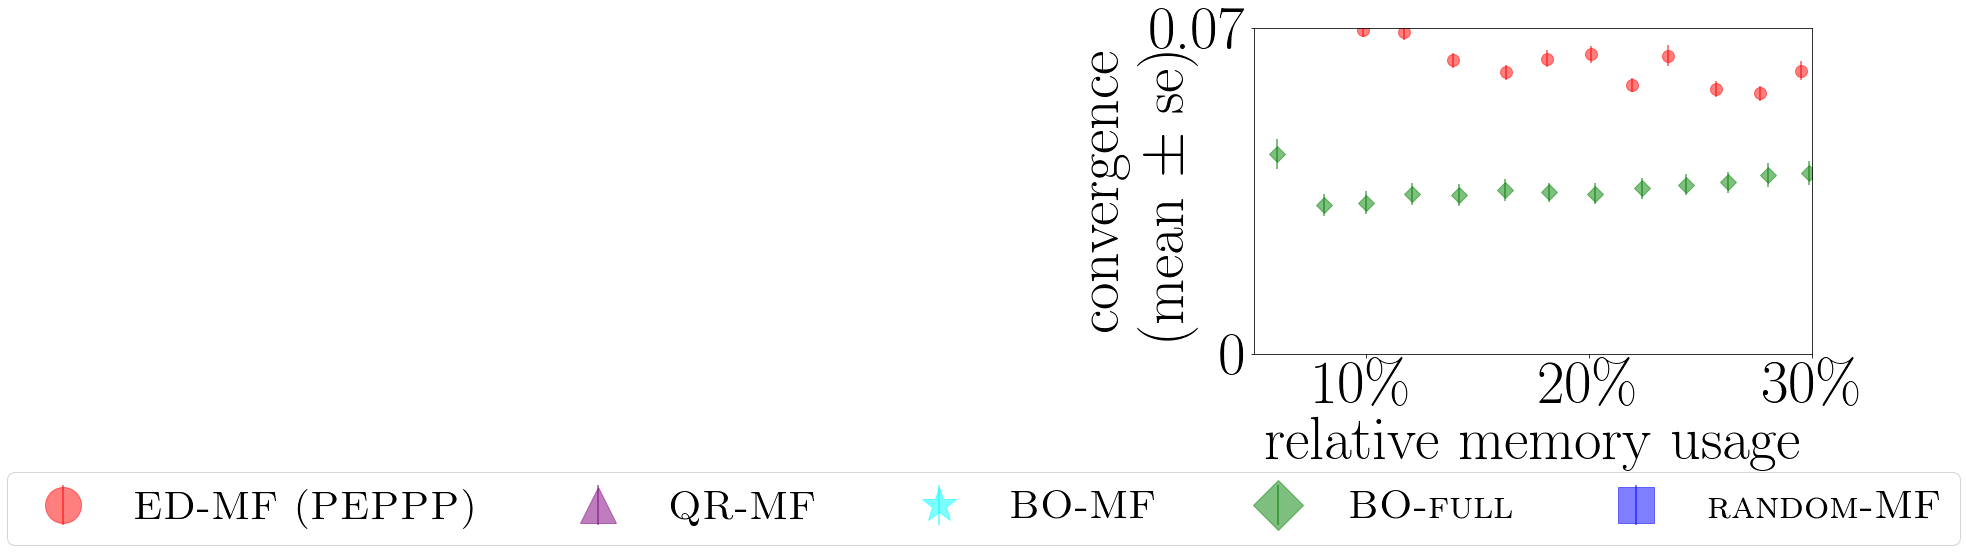

In [53]:
#with errorbar
elinewidth = 2
fontsize_axes = 60
legend_marker_size = 40
linewidth = 5
markersize = 12

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red', 'blue', 'cyan', 'purple', 'green', 'orange']

ax.errorbar(np.median(percentage_memory_all_datasets_ed, axis=0), np.mean(dist_all_mean_all_datasets_ed, axis=0), sem(dist_all_mean_all_datasets_ed, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[0], fmt='o', ms=markersize, linewidth=linewidth, elinewidth=elinewidth, label=r'\textsc{ED-MF (PEPPP)}', alpha=0.5)

ax.errorbar(np.median(percentage_memory_all_datasets_qr, axis=0), np.mean(dist_all_mean_all_datasets_qr, axis=0), sem(dist_all_mean_all_datasets_ed, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[3], fmt='^', ms=markersize, linewidth=linewidth, elinewidth=elinewidth, label=r'\textsc{QR-MF}', alpha=0.5)

ax.errorbar(np.median(percentage_memory_all_datasets_gp, axis=0), np.mean(dist_all_mean_all_datasets_gp, axis=0), sem(dist_all_mean_all_datasets_gp, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[2], fmt='*', ms=markersize, linewidth=linewidth, elinewidth=elinewidth, label=r'\textsc{BO-MF}', alpha=0.5)

ax.errorbar(np.median(percentage_memory_all_datasets_gp_full, axis=0), np.mean(dist_all_mean_all_datasets_gp_full, axis=0), sem(dist_all_mean_all_datasets_gp_full, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[4], fmt='D', ms=markersize, linewidth=linewidth, elinewidth=elinewidth, label=r'\textsc{BO-full}', alpha=0.5)
ax.errorbar(np.median(percentage_memory_all_datasets_random, axis=0), np.mean(dist_all_mean_all_datasets_random, axis=0), sem(dist_all_mean_all_datasets_random, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[1], fmt='s', alpha=.5, ms=markersize, linewidth=linewidth, elinewidth=elinewidth, label=r'\textsc{random-MF}')
# ax.errorbar(observation_ratios, prediction_errors_mean, prediction_errors_std, color=colors[0], drawstyle='steps-post', linewidth=linewidth, elinewidth=elinewidth)

ax.set_xlabel('relative memory usage', fontsize=fontsize_axes)
ax.set_ylabel('convergence \n (mean $\pm$ se)', fontsize=fontsize_axes)
ax.yaxis.set_label_coords(-0.1,0.5)


if setting_id in set([6, 4, 2]):
    vals_xticks = [0.1, 0.2, 0.3]
    vals_ytick = [0, 0.07]
    xmin = 0.05
    xmax = 0.3
    ymin = 0
    ymax = 0.07
elif setting_id in set([1, 3, 5]):
    vals_xticks = [0.05, 0.1]
    vals_ytick = [0, 0.1]
    xmin = 0.02
    xmax = 0.1
    ymin = 0
    ymax = 0.1
    
percentage_xticks = ['{:.0f}\%'.format(100*item) for item in vals_xticks]
ax.set_xticks(vals_xticks)
ax.set_xticklabels(percentage_xticks, fontsize=fontsize_axes)

ax.set_yticks(vals_ytick)
ax.set_yticklabels(vals_ytick, fontsize=fontsize_axes)

plt.xlim(left=xmin, right=xmax)
legend = plt.legend(loc='lower', bbox_to_anchor=(1.3, -.3), fontsize=legend_marker_size, ncol=5, markerscale=3)
plt.xticks(fontsize=fontsize_axes)
plt.yticks(fontsize=fontsize_axes)
plt.ylim(bottom=ymin, top=ymax)

HyperDiff

(0.05, 0.3)

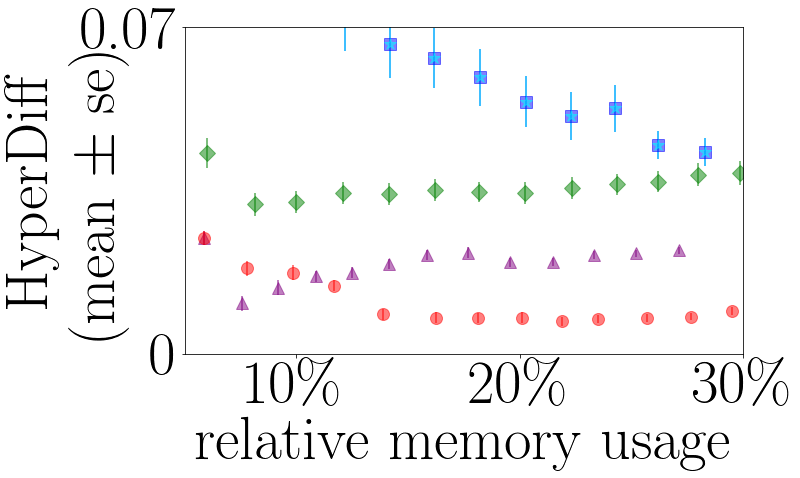

In [54]:
#with errorbar
elinewidth = 2
fontsize_axes = 60
legend_marker_size = 40
linewidth = 3
markersize = 12

fig, ax = plt.subplots(figsize=(10, 6))
colors = ['red', 'blue', 'cyan', 'purple', 'green', 'orange']

ax.errorbar(np.median(percentage_memory_all_datasets_qr, axis=0), np.mean(hd_all_mean_all_datasets_qr, axis=0), sem(hd_all_mean_all_datasets_ed, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[3], fmt='^', ms=markersize, linewidth=linewidth, elinewidth=elinewidth, label=r'\textsc{QR-MF}', alpha=0.5)

ax.errorbar(np.median(percentage_memory_all_datasets_ed, axis=0), np.mean(hd_all_mean_all_datasets_ed, axis=0), sem(hd_all_mean_all_datasets_ed, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[0], fmt='o', ms=markersize, linewidth=linewidth, elinewidth=elinewidth, label=r'\textsc{ED-MF (PEPPP)}', alpha=0.5)
ax.errorbar(np.median(percentage_memory_all_datasets_random, axis=0), np.mean(hd_all_mean_all_datasets_random, axis=0), sem(hd_all_mean_all_datasets_random, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[1], fmt='s', ms=markersize, linewidth=linewidth, elinewidth=elinewidth, label=r'\textsc{random-MF}', alpha=0.5)
ax.errorbar(np.median(percentage_memory_all_datasets_gp, axis=0), np.mean(hd_all_mean_all_datasets_gp, axis=0), sem(hd_all_mean_all_datasets_gp, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[2], fmt='*', ms=markersize, linewidth=linewidth, elinewidth=elinewidth, label=r'\textsc{BO-MF}', alpha=0.5)

ax.errorbar(np.median(percentage_memory_all_datasets_gp_full, axis=0), np.mean(dist_all_mean_all_datasets_gp_full, axis=0), sem(dist_all_mean_all_datasets_gp_full, axis=0, ddof=0, nan_policy='omit'), 
            color=colors[4], fmt='D', ms=markersize, linewidth=linewidth, elinewidth=elinewidth, label=r'\textsc{BO-full}', alpha=0.5)

ax.set_xlabel('relative memory usage', fontsize=fontsize_axes)
ax.set_ylabel('HyperDiff \n (mean $\pm$ se)', fontsize=fontsize_axes)
ax.yaxis.set_label_coords(-0.1,0.5)

# vals_xticks = [0.2, 0.4, 0.6]
if setting_id in set([6, 4, 2]):
    vals_xticks = [0.1, 0.2, 0.3]
    vals_ytick = [0, 0.07]
    xmin = 0.05
    xmax = 0.3
    ymin = 0
    ymax = 0.07
elif setting_id in set([1, 3, 5]):
    vals_xticks = [0.05, 0.1]
    vals_ytick = [0, 0.1]
    xmin = 0.02
    xmax = 0.1
    ymin = 0
    ymax = 0.1
    
percentage_xticks = ['{:.0f}\%'.format(100*item) for item in vals_xticks]
ax.set_xticks(vals_xticks)
ax.set_xticklabels(percentage_xticks, fontsize=fontsize_axes)


ax.set_yticks(vals_ytick)
ax.set_yticklabels(vals_ytick, fontsize=fontsize_axes)

plt.xticks(fontsize=fontsize_axes)
plt.yticks(fontsize=fontsize_axes)
plt.ylim(bottom=ymin, top=ymax)
plt.xlim(left=xmin, right=xmax)